<h1>Затяжные пожары</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

SQL запрос:

SELECT FR2021.F1, FR2021.F5, FR2021.F6, FR2021.F193, т08F12_Объекты.ОбъектТактика2 AS F12, FR2021.F14, FR2021.F15, FR2021.F16, FR2021.F26, FR2021.F63, FR2021.F64, F157, F158, F69, F70, FR2021.F159, FR2021.F160, FR2021.F71, т17F72_74_УслРазвПожара.F72_74гр AS F72, FR2021.F83, FR2021.F84, FR2021.F85, FR2021.F86, FR2021.F87, F88, F89, F90, FR2021.F91, FR2021.F92, FR2021.F93
FROM т17F72_74_УслРазвПожара INNER JOIN (т08F12_Объекты INNER JOIN FR2021 ON т08F12_Объекты.F12 = FR2021.F12) ON т17F72_74_УслРазвПожара.F72_74 = FR2021.F72
WHERE (((FR2021.F1)=1144 Or (FR2021.F1)=1146 Or (FR2021.F1)=1176) AND ((FR2021.F4)=0));

Словарь:
during fire extinguishing - время тушения пожара

In [2]:
class FireLong():
    # Расход стволов:
    flw = {0: 0, 1: 7, 2: 3.5, 3: 20, 4: 6,
           5: 0, 6: 3.5, 7: 3.5, 8: 3.5, 9: 3.5}
    # Количество дней в месяцах
    dm = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30,
          7: 31, 8: 31, 9: 30, 10: 31, 11: 20, 12: 31}
    # Количество дней от начала года до заданного месяца
    dms = {1: 0, 2: 31, 3: 59, 4: 90, 5: 120, 6: 151, 7: 181,
           8: 212, 9: 243, 10: 273, 11: 304, 12: 334}
    

    def leap_year(self, y):
        # Количество дней в году
        if (y % 4 == 0 and y % 100 != 0) or y % 400 == 0:
            return 366
        else:
            return 365

    def day_month(self, m, y):
        # Високосный год
        if self.leap_year(y) == 366 and m > 1:
            leap = 1
        else:
            leap = 0

        if m > 0 and m < 13:
            return self.dms[m] + leap
        else:
            return 0

    def BeetweenTime(self, d_start, hs, ms, d_finish, hf, mf):
        '''Количество минут в интевале между метками, заданными
        датой и временем
        '''
        day_st = d_start.split()[0].split('.')
        day_fn = d_finish.split()[0].split('.')

        dst, dfn = int(day_st[0]), int(day_fn[0])  # Количество дней
        # Количество дней от января до месяца
        mst, mfn = int(day_st[1]), int(day_fn[1])
        yst, yfn = int(day_st[2]), int(day_fn[2])

        # Минуты
        m = int(eval(f'60*({hf}-{hs})+{mf}-{ms}'))

        d = 0
        if day_st != day_fn:  # Вычисление разности в днях между месяцами
            d = dfn + self.day_month(mfn, yfn) - dst - self.day_month(mst, yst)

        if yst != yfn:  # Вычисление разности в днях между годами
            d += 365 * (yfn - yst)

        res = d*1440 + m

        return res

    def decade(self, data):  # Вычисление номера декады года
        d1 = data.split('.')
        if len(d1[2]) > 4:
            d1[2] = d1[2][:4]

        d, m, y = int(d1[0]), int(d1[1]), int(d1[2])
        d += self.day_month(m, y)
        return (d-1) // 10 + 1

    def flow(self, s1, s2, s3, n1, n2, n3):
        # Передача параметров функции по раздельности выполняется быстрее,
        # чем если передавать срез строки фрейма
        ''' Определение суммарного расхода воды
        0 Не указан - 0
        1 Ствол А - 7 л/с
        2 Ствол Б - 3.5 л/с
        3 Ствол лафетный - 20 л/с
        4 Ствол пенный - 6 л/с
        5 Ствол порошковый 0
        6 Ствол водопенный - 6 л/с 
        7 Ствол высокого давления - 3.5 л/с
        8 Ствол ручной - универсальный - 3.5 л/с
        9 Ствол ручной - комбинированный - 3.5 л/с
        '''
        return self.flw[s1]*n1 + self.flw[s2]*n2 + self.flw[s3]*n3
    
    def jitter(self, data, stdev):
        '''Дрожжание точек - добавление разброса для координат'''
        N = len(data)
        return data + np.random.randn(N) * stdev

f = FireLong()

In [129]:
# d = pd.read_csv('long.csv')
d.shape

(26389, 30)

In [8]:
# Начальная выборка 26389х203
# После отбора осталось 30 колонок
d1 = pd.read_csv('long.csv', encoding='1251')  # Кодировка Windows-1251

# Понижение разрядности float -> integer
cols = list(d1.select_dtypes(include='float').columns)
d1[cols] = d1[cols].astype(int)

# Время занятости - интервал: получение вызова - ликвидация последствий
d1['Busy'] = [f.BeetweenTime(d1.F5.loc[i], d1.F63.loc[i], d1.F64.loc[i],
                             d1.F71.loc[i], d1.F159.loc[i], d1.F160.loc[i])
              for i in range(d1.shape[0])]
mask = d1.Busy < 10  # Все некорректные значения заменяются на 10
d1.loc[mask, 'Busy'] = 10


# Время тушения - интервал: подача 1-го ствола - ликвидация открытого горения
d1['Exting'] = [f.BeetweenTime(d1.F5.loc[i], d1.F157.loc[i], d1.F158.loc[i],
                             d1.F71.loc[i], d1.F69.loc[i], d1.F70.loc[i])
              for i in range(d1.shape[0])]
mask = d1.Exting < 3  # Все некорректные значения заменяются на 3
d1.loc[mask, 'Exting'] = 3

mask = d1.Busy < d1.Exting  # Время тушения превышает время занятости
d1.loc[mask, 'Exting'] = d1.Exting - 1440

mask = d1.Exting < 3
d1.loc[mask, 'Exting'] = 3


# Декады
d1['Decade'] = [f.decade(d1.F5.loc[i]) for i in range(d1.shape[0])]

# Удаление колонок даты и времени - больше не нужны
cols = 'F5 F63 F64 F157 F158 F69 F70 F159 F160 F71'.split()
d1 = d1.drop(columns=cols)

# Населенные пункты: 1 - города; 0 - сельская местность
mask = d1.F6 == 2  # Поселки городского типа  -> Город
d1.loc[mask, 'F6'] = 1
mask = d1.F6 != 1  # Все остальное село == 0
d1.loc[mask, 'F6'] = 0

# Категория риска от 5 до 0 (5 - самая высокая)
mask = d1.F193 != 99
d1.loc[mask, 'F193'] = -0.1*d1.F193 + 6
mask = d1.F193 == 99
d1.loc[mask, 'F193'] = 0
d1.F193 = d1.F193.astype(int)

# F12 - Объект пожара - Тактика2
'''
0	Не классифицировано
1	Производственные здания
2	Жилые здания и постройки
3	Общественные здания
4	Складские здания
5	Транспорт
6	Открытые территории
9	Прочие
'''

'''  F14 - этажность здания; F15 - этаж пожара 
90	Цокольный - с 2009 года код вместо 90 стал 900 и т.д.
91	Подвальный
92	Мансардный
93	Технический
94	Подземный 1
95	Подземный 2
96	Подземный 3
97	Подземный 4
98	Чердачный'''
mask = d1.F15.isin([900, 901, 904])
d1.loc[mask, 'F15'] = -1
mask = d1.F15.isin([905, 906, 907])
d1.loc[mask, 'F15'] = -1 * d1.F15 + 903
mask = d1.F16.isin([902, 902, 908])
d1.loc[mask, 'F15'] = d1.F14

# F16 - степень огнестойкости
mask = d1.F16 == 6
d1.loc[mask, 'F16'] = 0

# Общее количество пожарной техники
cols = 'F83 F84 F85 F86 F87'.split()
d1['Car'] = d1[cols].sum(axis=1)
d1 = d1.drop(columns=cols)

# Общее количество ствол
d1['Nozzle'] = d1[['F91', 'F92', 'F93']].sum(axis=1)
mask = d1.Nozzle == 0  # Стволы не подавались
d1.loc[mask, 'Exting'] = 0  # Расход воды = 0


# Общий расход воды, л/с
d1['Flow'] = [f.flow(d1.F88.loc[i], d1.F89.loc[i], d1.F90.loc[i], 
                      d1.F91.loc[i], d1.F92.loc[i], d1.F93.loc[i])
              for i in range(d1.shape[0])]
d1 = d1.drop(columns=['F88', 'F89', 'F90', 'F91', 'F92', 'F93'])

# F99 - использование ГДЗС
mask = d1.F99 > 0
d1.loc[mask, 'F99'] = 1

print('Очищенная выборка')
d1.head()

Очищенная выборка


,F1,F6,F193,F12,F14,F15,F16,F26,F157,F158,...,F72,F99,S,F149,Busy,Exting,Decade,Car,Nozzle,Flow
0,1144,1,1,2,1,1,5,4,1,9,...,1,0,20,частный дом,76,24,2,2,2,7.0
1,1144,1,1,1,1,1,3,3,7,0,...,1,0,3,частный гараж,269,46,2,1,2,7.0
2,1144,1,1,1,1,1,3,2,21,41,...,1,0,43,гараж,152,42,3,1,2,7.0
3,1144,1,0,6,0,0,0,2,18,4,...,0,0,10,мусор на открытой территории,25,10,1,1,1,3.5
4,1144,1,1,1,1,1,3,2,11,12,...,0,12,20,"Ремонтный бокс ООО ""Спецавтострой""",37,12,1,8,2,7.0


In [23]:
# Загрузка очищенных данных
d1 = pd.read_csv('Long_R1.csv', sep=';', decimal=',')
d1.head()

,F1,F6,F193,F12,F14,F15,F16,F26,F72,F99,S,Busy,Exting,Decade,Car,Nozzle,Flow,Long
0,1144,1,1,2,1,1,5,4,1,0,20,76,24,2,2,2,7.0,0
1,1144,1,1,1,1,1,3,3,1,0,3,269,46,2,1,2,7.0,0
2,1144,1,1,1,1,1,3,2,1,0,43,152,42,3,1,2,7.0,0
3,1144,1,0,6,0,0,0,2,0,0,10,25,10,1,1,1,3.5,0
4,1144,1,1,1,1,1,3,2,0,1,20,37,12,1,8,2,7.0,0


<h3>Предварительная оценка распределений</h3>

In [24]:
# Иформация о выборке
d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26389 entries, 0 to 26388
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      26389 non-null  int64  
 1   F6      26389 non-null  int64  
 2   F193    26389 non-null  int64  
 3   F12     26389 non-null  int64  
 4   F14     26389 non-null  int64  
 5   F15     26389 non-null  int64  
 6   F16     26389 non-null  int64  
 7   F26     26389 non-null  int64  
 8   F72     26389 non-null  int64  
 9   F99     26389 non-null  int64  
 10  S       26389 non-null  int64  
 11  Busy    26389 non-null  int64  
 12  Exting  26389 non-null  int64  
 13  Decade  26389 non-null  int64  
 14  Car     26389 non-null  int64  
 15  Nozzle  26389 non-null  int64  
 16  Flow    26389 non-null  float64
 17  Long    26389 non-null  int64  
dtypes: float64(1), int64(17)
memory usage: 3.6 MB


F1 - Субъект РФ<br>
F6 - Вид населенного пункта<br>
F193 - Категория риска объекта пожара<br>
F12 - Объект пожара<br>
F14 - Этажность здания<br>
F15 - Этаж, на котором возник пожар<br>
F16 - Степень огнестойкости<br>
F26 - Расстояние до пожарной части<br>
F72 - Условия, способств. развитию пожара<br>
F99 - Использование СИЗОД<br>
S - Площадь пожара<br>
Busy - Время занятости на пожаре<br>
Exting - Время подачи стволов<br>
Decade - Номер декады года<br>
Car - Общее количество техники, ед.<br>
Nozzle - Общее количество стволов, ед.<br>
Flow - Расход воды на тушени, л/с<br>
Long - Признак затяжного пожара (0,1)<br>

columns=['F1','F12','F193','F72']

In [21]:
# Количество пожаров по регионам
print('Количество пожаров по регионам:\n', d1.groupby('F1').size())
print('Количество автомобилей по регионам:\n', d1.groupby('F1')['Car'].sum())

Количество пожаров по регионам:
 F1
1144      877
1146    20520
1176     4992
dtype: int64
Количество автомобилей по регионам:
 F1
1144     1472
1146    38439
1176     7471
Name: Car, dtype: int64


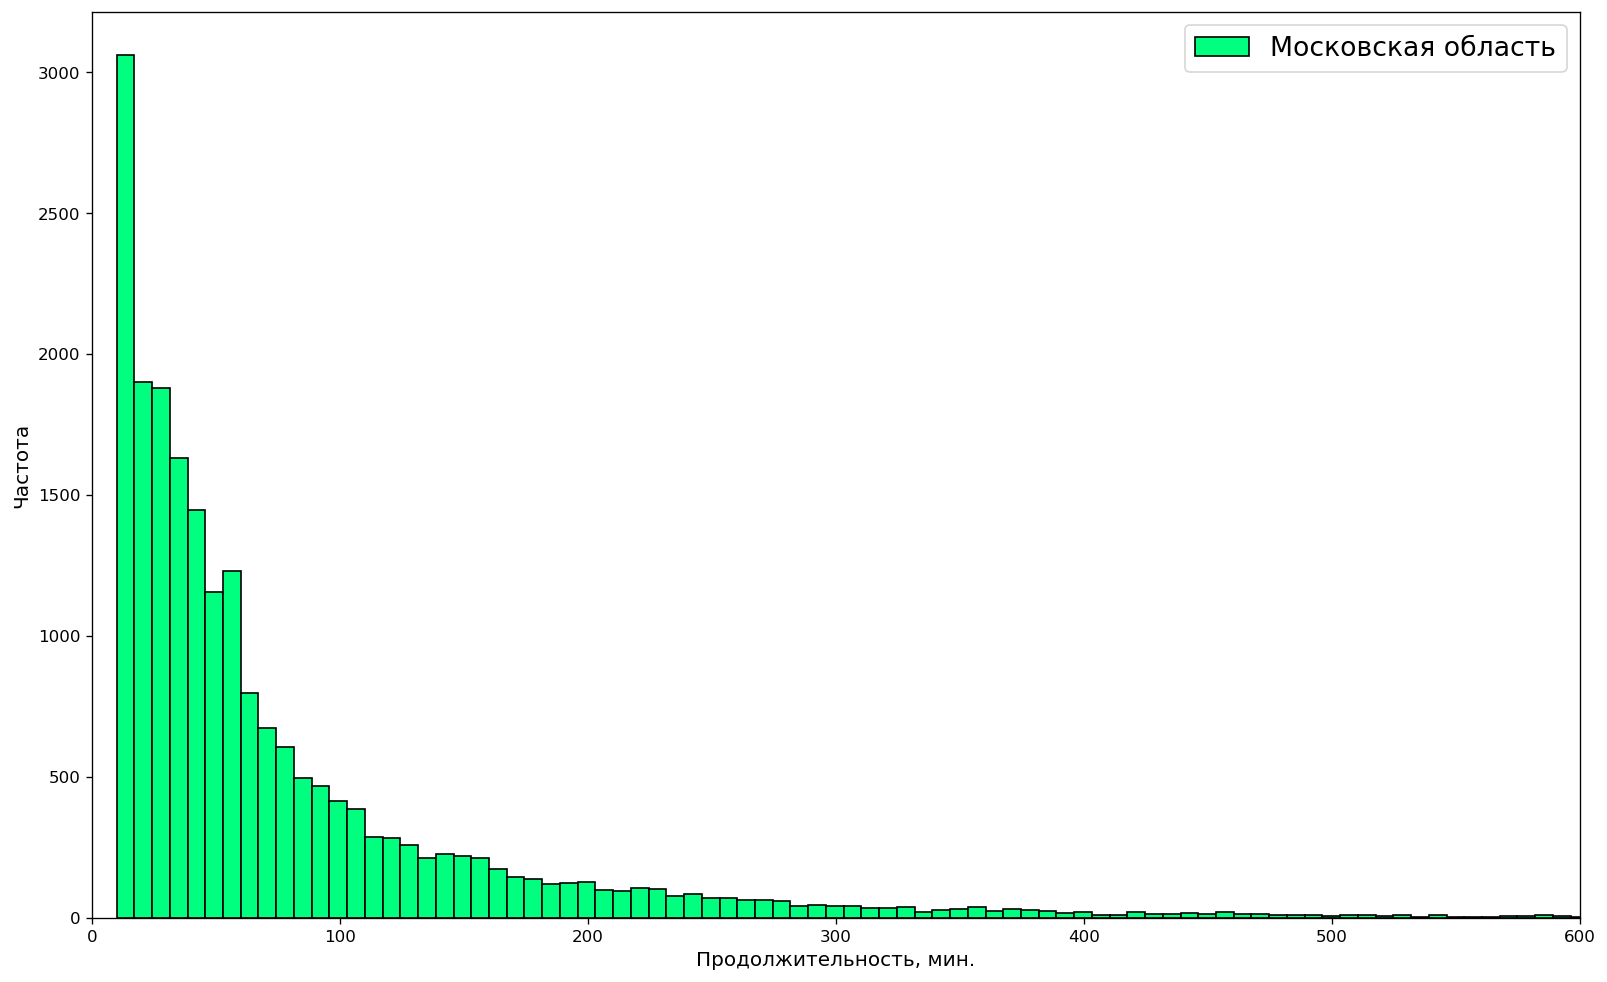

In [22]:
d2 = d1.copy()

h1 = d2.Busy[d2.F1==1146]
h2 = d2.Busy[d2.F1==1144]
h3 = d2.Busy[d2.F1==1176]
 
n = 800
plt.figure(figsize=(16, 10), dpi= 120, facecolor='w', edgecolor='gray')
plt.hist(h1, label='Московская область', color='SpringGreen', edgecolor='Black', bins = n)
plt.xlabel('Продолжительность, мин.', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.xlim(0, 600)
plt.xscale('linear')  # logit log symlog linear
plt.legend(fontsize=16)
plt.savefig('picture/pic002.png', dpi=100, bbox_inches='tight') 
plt.show()

In [127]:
print('Количество пожаров в Московской области ликвидируемых за ограниченное время')
print(d2.Busy.loc[(d2.F1 == 1146) & (d2.Busy < 61)].value_counts().sum())
print('Среднее время занятости по регионам и объектам:')
print(d1.groupby(['F1','F12'])['Busy'].mean())

Количество пожаров в Московской области ликвидируемых за ограниченное время
12307
Среднее время занятости по регионам и объектам:
F1    F12
1144  1       65.935065
      2       60.853755
      3       92.285714
      4       49.666667
      5       30.333333
      6       50.011574
      9       20.000000
1146  1      125.576023
      2      128.690665
      3      108.425612
      4      381.917910
      5       32.494915
      6       57.154367
      9       27.850000
1176  1       78.352941
      2       62.542017
      3       60.706806
      4      111.782609
      5       33.464286
      6       42.755628
      9       32.250000
Name: Busy, dtype: float64


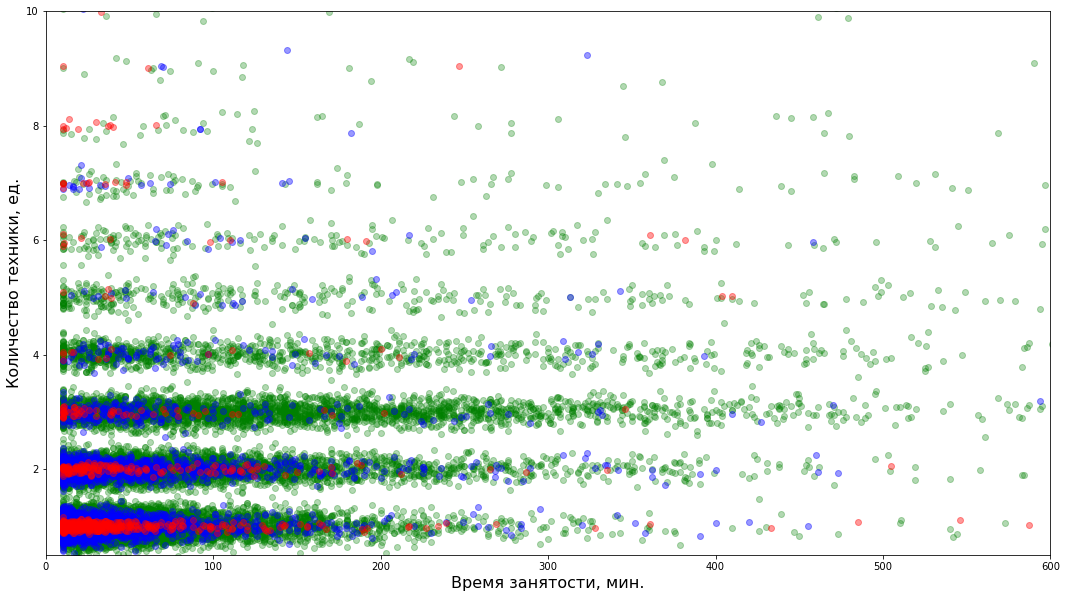

In [66]:
colrDict = {1144: 'red', 1146: 'green', 1176: 'blue'}

fig, ax = plt.subplots(figsize = (18,10))
Reg = 1146
ax.scatter(d2[d2.F1==Reg].Busy, f.jitter(d2[d2.F1==Reg].Car, 0.15), alpha=0.3, c=colrDict[Reg])
Reg = 1176
ax.scatter(d2[d2.F1==Reg].Busy, f.jitter(d2[d2.F1==Reg].Car, 0.12), alpha=0.4, c=colrDict[Reg])
Reg = 1144
ax.scatter(d2[d2.F1==Reg].Busy, f.jitter(d2[d2.F1==Reg].Car, 0.05), alpha=0.4, c=colrDict[Reg])

plt.xlim(0, 600)
plt.ylim(0.5, 10)
ax.set_xlabel('Время занятости, мин.', size=16)
ax.set_ylabel('Количество техники, ед.', size=16)
plt.xscale('linear')  # logit log symlog linear
plt.savefig('picture/pic001.png', dpi=100, bbox_inches='tight') 
plt.show()


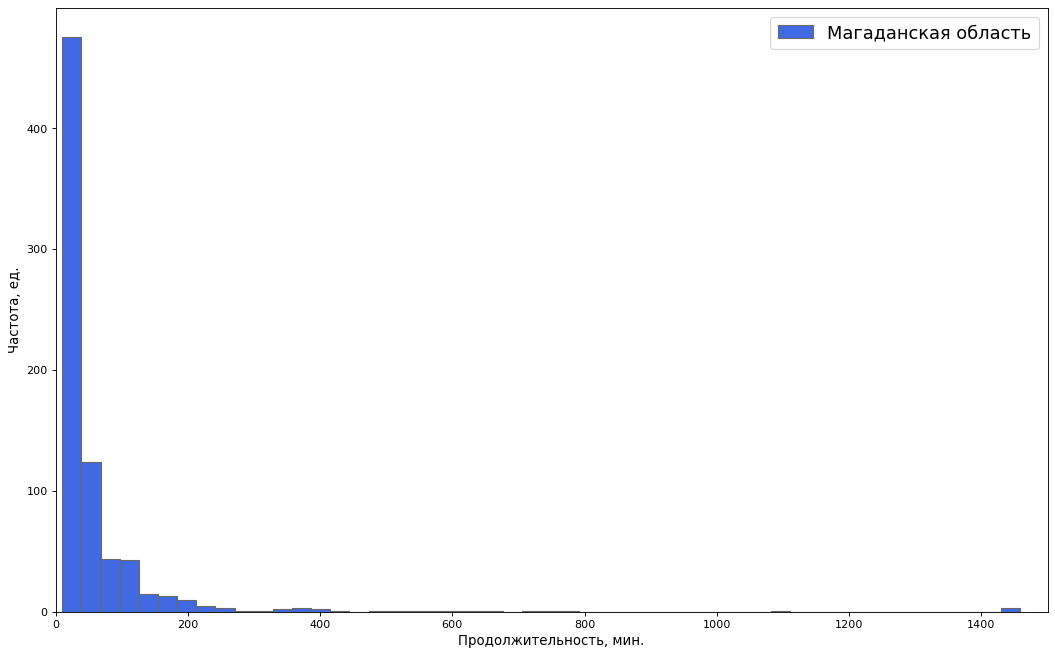

In [132]:
n = 50
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(h2, label='Магаданская область', color='RoyalBlue', edgecolor='DimGray', bins = n)
plt.xlabel('Продолжительность, мин.', fontsize=12)
plt.ylabel('Частота, ед.', fontsize=12)
plt.xlim(0, 1500)
plt.legend(fontsize=16)
plt.show()

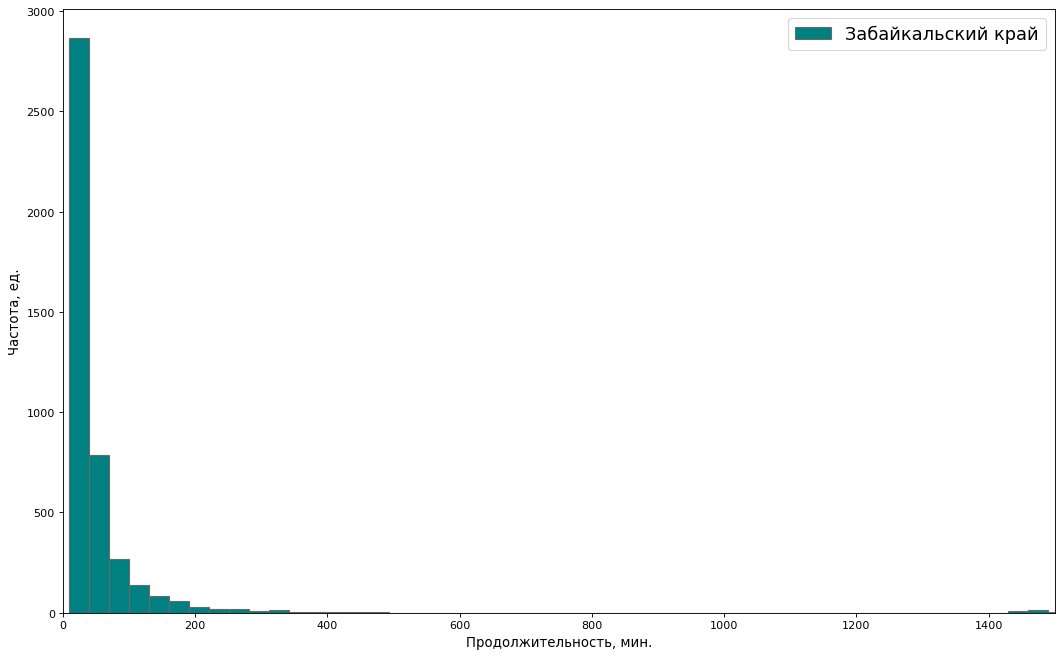

In [133]:
n = 50
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(h3, label='Забайкальский край', color='Teal', edgecolor='DimGray', bins = n)
plt.xlabel('Продолжительность, мин.', fontsize=12)
plt.ylabel('Частота, ед.', fontsize=12)
plt.xlim(0, 1500)
plt.legend(fontsize=16)
plt.show()

In [194]:
print('Мода показателя Busy для субъектов:')
for i in d1.F1.unique():
    print(i, d1[d1.F1==i].Busy.mode()[0])

Мода показателя Busy для субъектов:
1144 11
1176 10
1146 20


In [197]:
print('Сводная статистика показателя Busy для субъектов:\n\
* рассматриваются только случаи Busy>9')
s, col = [], d1.F1.unique()
for i in col:
    s.append(d1.Busy.loc[((d1.F1==i) & (d1.Busy>9))].describe())
    
result = pd.concat(s, axis=1)
result.columns=col
result 

Сводная статистика показателя Busy для субъектов:
* рассматриваются только случаи Busy>9


,1144,1176,1146
count,757.000000,4343.000000,19241.000000
mean,63.240423,54.475248,90.323372
std,129.816345,122.912957,136.188209
min,10.000000,10.000000,10.000000
25%,18.000000,17.000000,29.000000
50%,29.000000,28.000000,51.000000
75%,55.000000,51.000000,102.000000
max,1458.000000,1520.000000,5730.000000


<h2>Создание обучающей выборки</h2>
<p>Выборка содержит категориальные показатели, которые необходимо преобразовать в числовые "фиктивные переменные"</p>

In [26]:
df = pd.get_dummies(d1, columns=['F1','F12','F193','F72'], drop_first= True )
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26389 entries, 0 to 26388
Data columns (total 35 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   F6       26389 non-null  int64  
 1   F14      26389 non-null  int64  
 2   F15      26389 non-null  int64  
 3   F16      26389 non-null  int64  
 4   F26      26389 non-null  int64  
 5   F99      26389 non-null  int64  
 6   S        26389 non-null  int64  
 7   Busy     26389 non-null  int64  
 8   Exting   26389 non-null  int64  
 9   Decade   26389 non-null  int64  
 10  Car      26389 non-null  int64  
 11  Nozzle   26389 non-null  int64  
 12  Flow     26389 non-null  float64
 13  Long     26389 non-null  int64  
 14  F1_1146  26389 non-null  uint8  
 15  F1_1176  26389 non-null  uint8  
 16  F12_2    26389 non-null  uint8  
 17  F12_3    26389 non-null  uint8  
 18  F12_4    26389 non-null  uint8  
 19  F12_5    26389 non-null  uint8  
 20  F12_6    26389 non-null  uint8  
 21  F12_9    263

In [111]:
d1.F12.value_counts()


6    15190
2     8138
3     1309
5     1079
1      487
4      160
9       26
Name: F12, dtype: int64

In [187]:
i = 1144
s1 = d1.Busy.loc[((d1.F1==i) & (d1.Busy>9))].describe()
i = 1146
s2 = d1.Busy.loc[((d1.F1==i) & (d1.Busy>9))].describe()

result = pd.concat([s1,s2], axis=1)
result

,Busy,Busy
count,757.000000,19241.000000
mean,63.240423,90.323372
std,129.816345,136.188209
min,10.000000,10.000000
25%,18.000000,29.000000
50%,29.000000,51.000000
75%,55.000000,102.000000
max,1458.000000,5730.000000


In [19]:
n = [0, 10]
for i in range(n[0], n[1]):
    print(f'{d1.F5.loc[i].split()[0]} {int(d1.F63.loc[i])}:{int(d1.F64.loc[i])}\
- {d1.F71.loc[i].split()[0]} {int(d1.F159.loc[i])}:{int(d1.F160.loc[i])} -',
         f.BeetweenTime(d1.F5.loc[i], d1.F63.loc[i], d1.F64.loc[i],
               d1.F71.loc[i], d1.F159.loc[i], d1.F160.loc[i]))

15.1.2021 1:3- 15.1.2021 2:19 - 76
19.1.2021 6:56- 19.1.2021 11:25 - 269
27.1.2021 21:32- 28.1.2021 0:4 - 152
4.1.2021 17:58- 4.1.2021 18:23 - 25
4.1.2021 11:6- 4.1.2021 11:43 - 37
4.1.2021 23:40- 4.1.2021 23:51 - 11
5.1.2021 12:18- 5.1.2021 12:43 - 25
6.1.2021 21:52- 6.1.2021 22:6 - 14
6.1.2021 19:52- 6.1.2021 20:4 - 12
7.1.2021 23:3- 7.1.2021 23:15 - 12


In [198]:
d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26389 entries, 0 to 26388
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   F1      26389 non-null  int32
 1   F6      26389 non-null  int32
 2   F193    26389 non-null  int32
 3   F194    26389 non-null  int32
 4   F12     26389 non-null  int32
 5   F14     26389 non-null  int32
 6   F15     26389 non-null  int32
 7   F16     26389 non-null  int32
 8   F17     26389 non-null  int32
 9   F17A    26389 non-null  int32
 10  F18     26389 non-null  int32
 11  F152    26389 non-null  int32
 12  F26     26389 non-null  int32
 13  F72     26389 non-null  int32
 14  F73     26389 non-null  int32
 15  F74     26389 non-null  int32
 16  F83     26389 non-null  int32
 17  F84     26389 non-null  int32
 18  F85     26389 non-null  int32
 19  F86     26389 non-null  int32
 20  F87     26389 non-null  int32
 21  F91     26389 non-null  int32
 22  F92     26389 non-null  int32
 23  F93     263